# Introduction
Montreal is the second most-populous city in Canada, and the size and the shape of the island of Montreal makes daily transportations a challenge. <br> A good classification of the different neighborhoods by types of venues could help planning the transportation resources in the different times of the day. For instance, an area with many bars and night-clubs will not require transportation resources (bus, taxi..) at the same time of the day as for an area with mainly offices or commercial venues. <br>
A taxi company could use a classification analysis on the neighborhood to plan a better dispatch of the taxi float at each time of the day. <br>
Also, the city transportation system, could also use this input along with all the statistics it is able to collect. It can also help for an expansion of the metro network which is likely to happen in Montreal in a close future. 

# Data

We will use the Foursquare API to get the number of venues by category for each neighbourhood. To request the API we need to create a dataset containing the coordinates of all neighborhoods of Montreal

#### Creation of the Neighborhood dataset

In [1]:
import numpy as np 
import pandas as pd
import json 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

We start by scraping the wikipedia page of the postal codes of Montreal

In [2]:
df = pd.read_html('https://fr.wikipedia.org/wiki/Liste_des_codes_postaux_canadiens_d%C3%A9butant_par_H')[2]
df.head()

,0,1,2,3,4,5,6,7,8
0,H0ANon assigné,H1APointe-aux-Trembles,H2ASaint-MichelEst,H3ACentre-ville de MontréalNord (Université Mc...,H4ANotre-Dame-de-GrâceNord-est,H5APlace Bonaventure,H7ADuvernay-Est,H8ANon assigné,H9ADollard-Des-OrmeauxNord-ouest
1,H0BNon assigné,H1BMontréal-Est,H2BAhuntsicNord,H3BCentre-ville de MontréalEst,H4BNotre-Dame-de-GrâceSud-ouest,H5BComplexe Desjardins,H7BSaint-François,H8BNon assigné,H9BDollard-Des-OrmeauxEst
2,H0CNon assigné,H1CRivière-des-PrairiesNord-est,H2CAhuntsicCentre,H3CGriffintown(Incluant Île Notre-Dame & Île S...,H4CSaint-Henri,H5CNon assigné,H7CSaint-Vincent-de-Paul,H8CNon assigné,H9CL'Île-BizardNord-est
3,H0ENon assigné,H1ERivière-des-PrairiesSud-ouest,H2EVillerayNord-est,H3EÎle des Sœurs,H4EVille Émard,H5ENon assigné,H7EDuvernay,H8ENon assigné,H9EL'Île-BizardSud-ouest
4,H0GNon assigné,H1GMontréal-NordNord,H2GPetite-PatrieNord-est,H3GCentre-ville de MontréalSud-est (Université...,H4GVerdunNord,H5GNon assigné,H7GPont-Viau,H8GNon assigné,H9GDollard-Des-OrmeauxSud-ouest


The format is not very friendly... so we change it

In [3]:
df2 =pd.DataFrame([df.loc[label,i] for label, row in df.iterrows() for i in range(9)])
df2["Postal Code"] = df2[0].str.slice(0,3)
df2["Neighborhood"] = df2[0].str.slice(3)
df2 = df2[["Postal Code","Neighborhood"]]
df2 = df2[df2["Neighborhood"] != "Non assigné"]
df2 = df2.reset_index(drop=True)
df2.head()

,Postal Code,Neighborhood
0,H1A,Pointe-aux-Trembles
1,H2A,Saint-MichelEst
2,H3A,Centre-ville de MontréalNord (Université McGill)
3,H4A,Notre-Dame-de-GrâceNord-est
4,H5A,Place Bonaventure


After many unsuccesfull tries with geopy geocode which is not reliable with incomplete addresses, I was lucky to find the geocoordinates for most of the postal codes on the web

In [4]:
df_add = pd.read_html('https://www.geonames.org/postal-codes/CA/QC/quebec.html')[2]
df_add.head()

,Unnamed: 0,Place,Code,Country,Admin1,Admin2,Admin3
0,1.0,Mont-Joli,G5H,Canada,Quebec,Bas-Saint-Laurent,Mont-Joli
1,NaN,48.584/-68.192,48.584/-68.192,48.584/-68.192,48.584/-68.192,48.584/-68.192,48.584/-68.192
2,2.0,Duvernay-Est,H7A,Canada,Quebec,NaN,NaN
3,NaN,45.674/-73.592,45.674/-73.592,45.674/-73.592,45.674/-73.592,45.674/-73.592,45.674/-73.592
4,3.0,Saint-Vincent-de-Paul,H7C,Canada,Quebec,NaN,NaN


Here again, we have to reformat

In [5]:
liste =[df_add.loc[label, "Code"] for label, row in df_add.iterrows()]
coordinate = []
postal = []
for j, i in enumerate(liste):
     if j % 2 != 0:
        coordinate.append(i) 
     elif j % 2 == 0:
        postal.append(i)
del postal[-1]
df_coord = pd.DataFrame({"Code":postal, "Coordonnées": coordinate})
df_coord["Latitude"] = df_coord["Coordonnées"].apply(lambda x: x.split("/")[0])
df_coord["Longitude"] = df_coord["Coordonnées"].apply(lambda x: x.split("/")[1])
df_coord.drop("Coordonnées", axis = 1, inplace = True)
df_add = df_add[df_add["Unnamed: 0"].notna()]
df_add = df_add[["Code","Place"]]
df_add_final = df_add.merge(df_coord, on = "Code")
df_add_final.head()

,Code,Place,Latitude,Longitude
0,G5H,Mont-Joli,48.584,-68.192
1,H7A,Duvernay-Est,45.674,-73.592
2,H7C,Saint-Vincent-de-Paul,45.617,-73.649
3,H7E,Duvernay,45.623,-73.695
4,H7G,Pont-Viau,45.577,-73.687


Now we can merge wikipedia data with the geocoordinates dataset:

In [6]:
df2.rename(columns = {"Postal Code": "Code"}, inplace = True)
df_add_final.set_index("Code", inplace =True)
df2.set_index("Code", inplace =True)
df_total = df2.join(df_add_final)
df_total["Latitude"] = df_total["Latitude"].astype(float)
df_total["Longitude"] = df_total["Longitude"].astype(float)
df_total.drop("Place", axis = 1, inplace = True)
df_total.head()

,Neighborhood,Latitude,Longitude
Code,,,
H1A,Pointe-aux-Trembles,NaN,NaN
H2A,Saint-MichelEst,NaN,NaN
H3A,Centre-ville de MontréalNord (Université McGill),45.504,-73.575
H4A,Notre-Dame-de-GrâceNord-est,45.472,-73.615
H5A,Place Bonaventure,NaN,NaN


To get the missing coordinates, the only solution is to search them manualy on google map, we will also use google map to modify unaccurate coordinates:

In [7]:
manual_search ={"H1A": [45.674145, -73.500435],
"H2A": [45.561809, -73.601338],
"H5A": [45.49984, -73.56597],
"H9A":[45.495801, -73.832858],
"H2B":[45.576195, -73.649025],
"H9B":[45.489237, -73.801538],
"H3C":[45.494434, -73.560541],
"H4C":[45.476287, -73.586520],
"H4Y":[45.457618, -73.749645],
"H3V":[45.495524, -73.611723],  
"H3H":[45.492761, -73.581189],
"H4P":[45.496358, -73.663880], 
"H3J":[45.486234, -73.573269],
"H9J":[45.450587, -73.873719],
"H3K":[45.481295, -73.558327],
"H9K":[45.457719, -73.893328],
"H3N":[45.528919, -73.629486],
"H8R":[45.42775, -73.646858],
"H9R":[45.460739, -73.813332],
"H1V":[45.559093, -73.542107],
"H1W":[45.544970, -73.547551],
"H9W":[45.431661, -73.866620],
"H3X":[45.482044, -73.64106],
"H2Y":[45.505745, -73.553612],
"H7Y":[45.531265, -73.856384],
"H8Y":[45.506451, -73.788071],
"H8Z":[45.505234, -73.839447],
"H8P":[45.425505, -73.605799]}
for key in manual_search:
    df_total.loc[key,"Latitude"] = manual_search.get(key)[0]
    df_total.loc[key,"Longitude"] = manual_search.get(key)[1]
df_total.head()

,Neighborhood,Latitude,Longitude
Code,,,
H1A,Pointe-aux-Trembles,45.674145,-73.500435
H2A,Saint-MichelEst,45.561809,-73.601338
H3A,Centre-ville de MontréalNord (Université McGill),45.504000,-73.575000
H4A,Notre-Dame-de-GrâceNord-est,45.472000,-73.615000
H5A,Place Bonaventure,45.499840,-73.565970


The last step is to get rid of some postal codes which are not usefull for the study (one is Santa Claus postal code, others correspond to some buildings in downtown Montreal)

In [8]:
df_total.drop(["H5B","H0P","H4Z","H0H","H5A"], axis=0,inplace=True)

Now we can display the neighborhoods on a map to check the result :

In [9]:
latitude = 45.508888
longitude = -73.561668
map_montreal= folium.Map(location=[latitude, longitude], zoom_start=10)

for cod, lat, lng, neighborhood in zip(df_total.index, df_total['Latitude'], df_total['Longitude'], df_total["Neighborhood"]):
    label = '{}, {}'.format(neighborhood,cod)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_montreal)  
    
map_montreal

We will limit the scope of the study to the island of Montreal so we get rid of the Neighborhoods North of Riviere-des-prairies

In [10]:
df_total.drop(["H7H", "H9E", "H9C","H7Y","H7X","H7R","H7P","H7T","H7W","H7V","H7N","H7S","H7L","H7K","H7M","H7G","H7A","H7B","H7C","H7E","H7J"], axis=0,inplace=True)

### Foursquare data : venues and categories

We will use Foursquare API to explore venue categories in each neighborhood. Venues can be categorized as residential, professional, shopping or leisure. We need to know what the venue categories are in the Foursquare database.

In [11]:
CLIENT_ID = 'BF1ZE5LH435VB50MRRDZXIC04N1EIZUFC4VYUM443TCWWQEM' # your Foursquare ID
CLIENT_SECRET = 'OXZOAIL5VYZEEKLS2H3QQI41FR2LFAI13IX2D4OITSEJ45XO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [12]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
results = requests.get(categories_url).json()

for i in range(len(results['response']['categories'])) :
    print(results['response']['categories'][i]["name"] +"    "+results['response']['categories'][i]["id"])

Arts & Entertainment    4d4b7104d754a06370d81259
College & University    4d4b7105d754a06372d81259
Event    4d4b7105d754a06373d81259
Food    4d4b7105d754a06374d81259
Nightlife Spot    4d4b7105d754a06376d81259
Outdoors & Recreation    4d4b7105d754a06377d81259
Professional & Other Places    4d4b7105d754a06375d81259
Residence    4e67e38e036454776db1fb3a
Shop & Service    4d4b7105d754a06378d81259
Travel & Transport    4d4b7105d754a06379d81259


Ther are 10 top categorize that we will use to classify the neighborhoods. We also extracted the id of the categories which will be the parameters to enter in the url requests

# Methodology
For each neighborhood, we will request to the Foursquare API the number of venues in each category

In [13]:
def count_venues(x, radius, category):
    latitude = df_total.loc[x,"Latitude"]
    longitude = df_total.loc[x,"Longitude"]
    url1 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latitude,
                longitude,
                radius,
                category)

    # make the GET request
    return requests.get(url1).json()['response']['totalResults']

In [14]:
for i in range(len(results['response']['categories'])) :
    df_total[results['response']['categories'][i]["name"]] = df_total.index.map(lambda x: count_venues(x,1000,results['response']['categories'][i]["id"]))
df_total.head()

,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Code,,,,,,,,,,,,,
H1A,Pointe-aux-Trembles,45.674145,-73.500435,1,1,0,4,0,5,2,0,4,5
H2A,Saint-MichelEst,45.561809,-73.601338,3,2,1,19,8,6,13,2,28,5
H3A,Centre-ville de MontréalNord (Université McGill),45.504000,-73.575000,57,80,4,186,88,77,83,36,108,88
H4A,Notre-Dame-de-GrâceNord-est,45.472000,-73.615000,17,1,0,84,6,9,25,2,51,6
H9A,Dollard-Des-OrmeauxNord-ouest,45.495801,-73.832858,0,2,0,5,2,4,4,0,2,2


We can calculate the total number of venues for each neighborhood:

In [15]:
df_total["Total venues"] = df_total[[results['response']['categories'][i]["name"]for i in range(len(results['response']['categories']))]].sum(axis=1)
df_total.head()

,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Total venues
Code,,,,,,,,,,,,,,
H1A,Pointe-aux-Trembles,45.674145,-73.500435,1,1,0,4,0,5,2,0,4,5,22
H2A,Saint-MichelEst,45.561809,-73.601338,3,2,1,19,8,6,13,2,28,5,87
H3A,Centre-ville de MontréalNord (Université McGill),45.504000,-73.575000,57,80,4,186,88,77,83,36,108,88,807
H4A,Notre-Dame-de-GrâceNord-est,45.472000,-73.615000,17,1,0,84,6,9,25,2,51,6,201
H9A,Dollard-Des-OrmeauxNord-ouest,45.495801,-73.832858,0,2,0,5,2,4,4,0,2,2,21


### Data exploration
Let's print a boxplot for the number of venues in each category to understand more the structure of the data

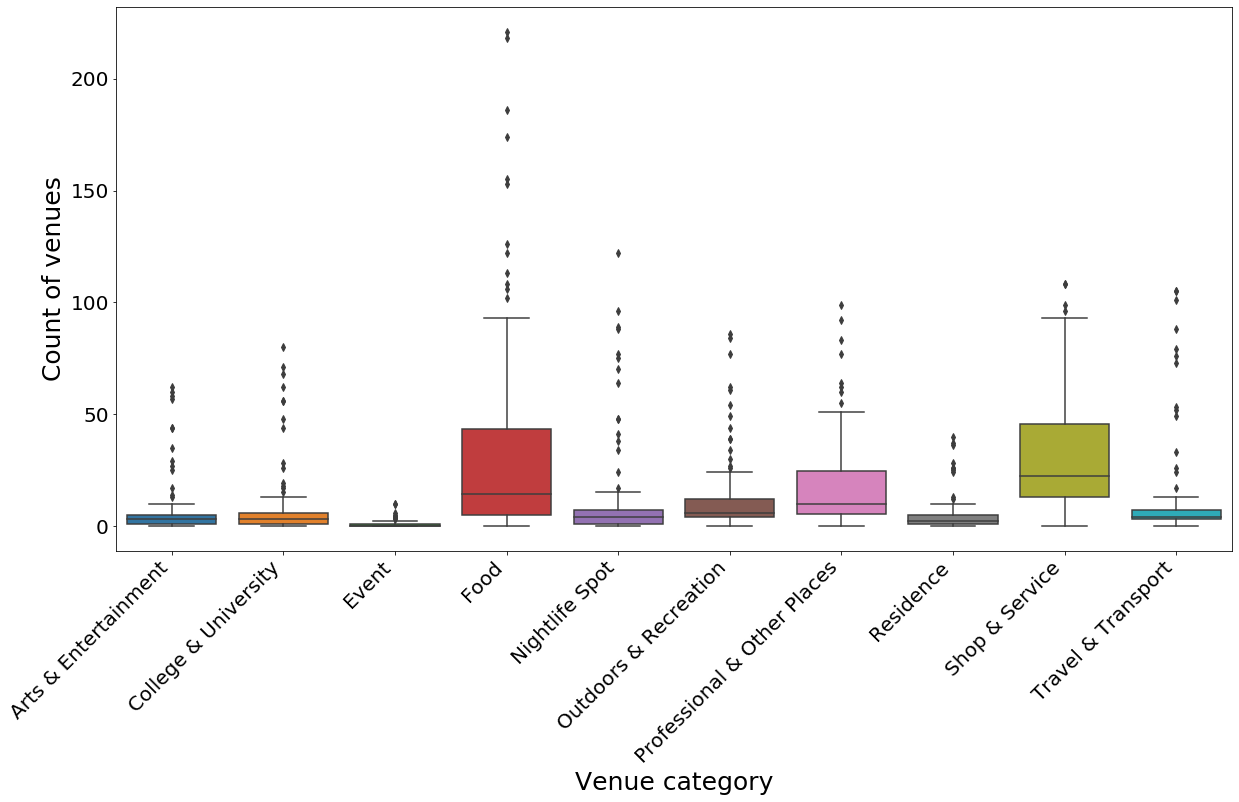

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

category_columns = df_total[[results['response']['categories'][i]["name"]for i in range(len(results['response']['categories']))]]
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data = category_columns)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

We see that the event & residence categories has very few numbers in the different areas, we can drop these categories as it won't make any big differences (Also most of residences are not in Foursquare data so it is not relevant to use this category)

In [17]:
df_total = df_total.drop(columns = ["Event","Residence"])
df_total.head()

,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total venues
Code,,,,,,,,,,,,
H1A,Pointe-aux-Trembles,45.674145,-73.500435,1,1,4,0,5,2,4,5,22
H2A,Saint-MichelEst,45.561809,-73.601338,3,2,19,8,6,13,28,5,87
H3A,Centre-ville de MontréalNord (Université McGill),45.504000,-73.575000,57,80,186,88,77,83,108,88,807
H4A,Notre-Dame-de-GrâceNord-est,45.472000,-73.615000,17,1,84,6,9,25,51,6,201
H9A,Dollard-Des-OrmeauxNord-ouest,45.495801,-73.832858,0,2,5,2,4,4,2,2,21


### Data preprocessing
We normalize the data with MinMaxScaler so each category has an equal impact on the study. Otherwise food places and shops would have a bigger impact due to their higher figures

In [24]:
from sklearn.preprocessing import MinMaxScaler

X = df_total.values[:,3:11]
data = MinMaxScaler().fit_transform(X)
df_cluster = pd.DataFrame(data)
df_cluster.columns = [results['response']['categories'][i]["name"]for i in [0,1,3,4,5,6,8,9]]
df_cluster.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0.016129,0.0125,0.018100,0.000000,0.058140,0.020202,0.037037,0.047619
1,0.048387,0.0250,0.085973,0.065574,0.069767,0.131313,0.259259,0.047619
2,0.919355,1.0000,0.841629,0.721311,0.895349,0.838384,1.000000,0.838095
3,0.274194,0.0125,0.380090,0.049180,0.104651,0.252525,0.472222,0.057143
4,0.000000,0.0250,0.022624,0.016393,0.046512,0.040404,0.018519,0.019048


Let's plot again the normalized data 

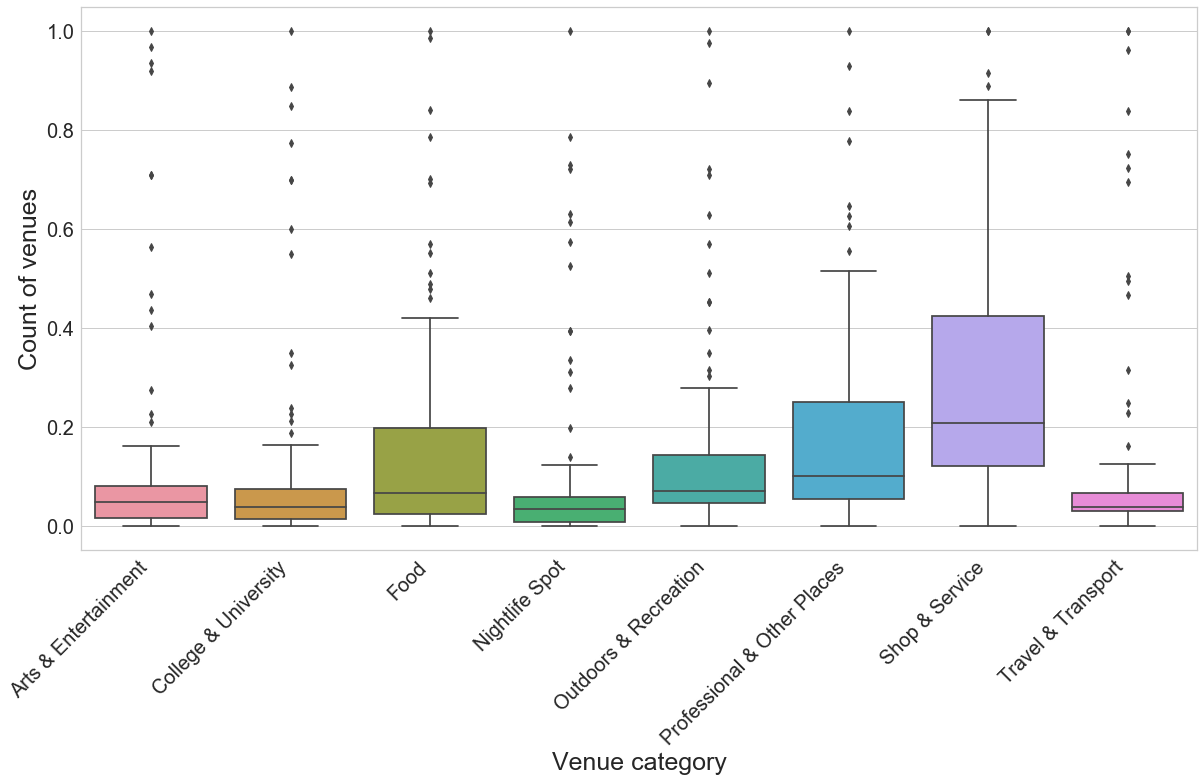

In [25]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data = df_cluster)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

### Clustering
By testing the k-means clustering algorithm with different number of clusters, we start from 2 and increasing up to 5 adds good and easy to interpret clustering but beyond 5 the clustering becomes difficult to interpret so we choose to keep a number of 5 clusters for the study.

To validate this empirical interpretation, we use the elbow method:

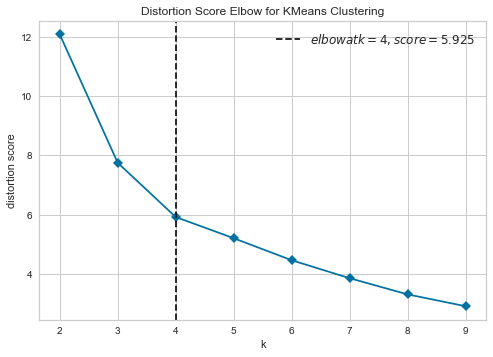

In [26]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)

visualizer.fit(df_cluster)        
visualizer.show()        

The elbow method (inflexion point of the distortion score of hte clusters) gives 4 as an optimal number of clusters...<br>
Since we still find a way to interpret the clustering with 5 clusters as we will see in the following plot we keep to 5

In [27]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(df_cluster)

df_cluster_result = df_cluster.copy()
df_cluster_result['Cluster'] = kmeans.labels_
df_cluster_result_global = df_total.copy()
df_cluster_result_global['Cluster'] = kmeans.labels_

df_cluster_result.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
0,0.016129,0.0125,0.018100,0.000000,0.058140,0.020202,0.037037,0.047619,3
1,0.048387,0.0250,0.085973,0.065574,0.069767,0.131313,0.259259,0.047619,1
2,0.919355,1.0000,0.841629,0.721311,0.895349,0.838384,1.000000,0.838095,0
3,0.274194,0.0125,0.380090,0.049180,0.104651,0.252525,0.472222,0.057143,4
4,0.000000,0.0250,0.022624,0.016393,0.046512,0.040404,0.018519,0.019048,3


We can use a boxplot in each cluster to help the interpretation

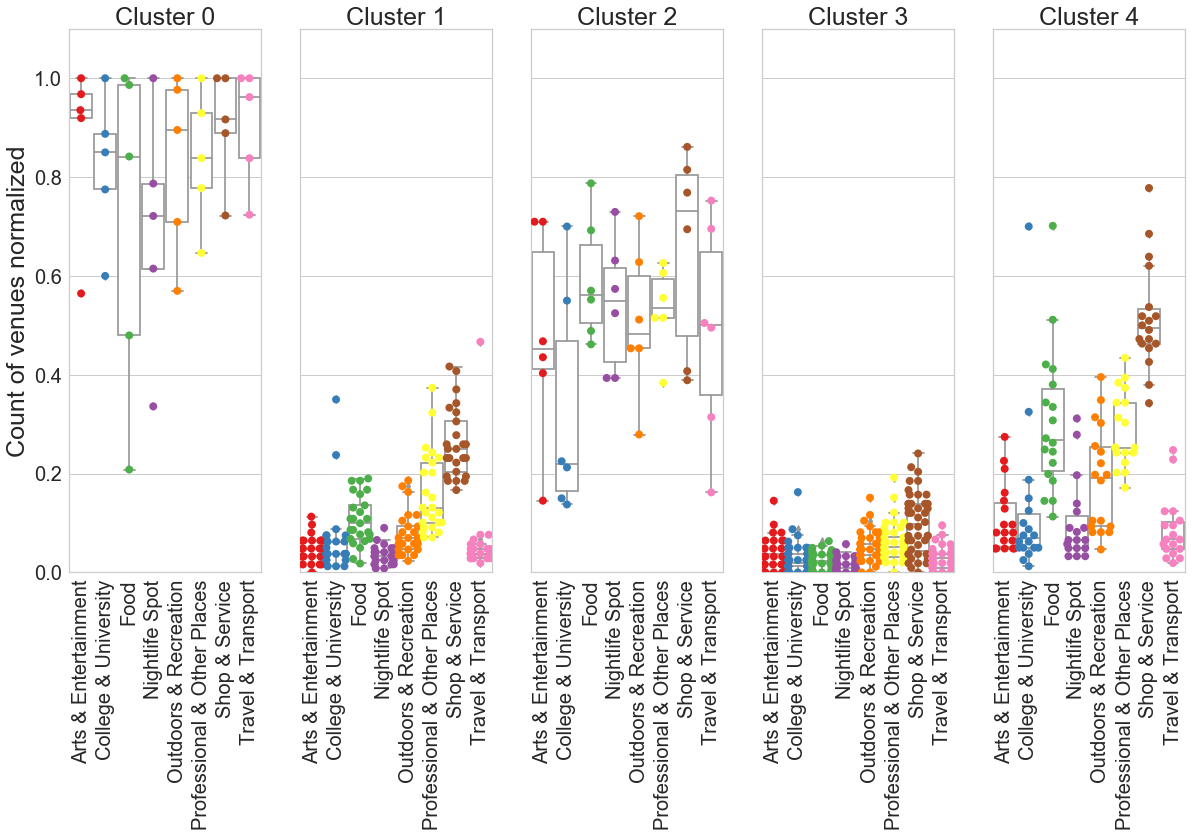

In [28]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues normalized', fontsize=25)


for k in range(kclusters):
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.swarmplot(data = df_cluster_result[df_cluster_result['Cluster'] == k].drop('Cluster', axis=1), ax=axes[k], palette="Set1", size=8)
    sns.boxplot(data = df_cluster_result[df_cluster_result['Cluster'] == k].drop('Cluster', axis=1), ax=axes[k], color='white', width=0.9)

plt.show()

Let's see the result on the map:

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors = {3:"yellow",2:"purple",1:"orange",4:"red",0:"black"}

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster_result_global['Latitude'], df_cluster_result_global['Longitude'], df_cluster_result_global['Neighborhood'], df_cluster_result_global['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors.get(cluster),
            fill=True,
            fill_color=colors.get(cluster),
            fill_opacity=0.99).add_to(map_clusters)
       
map_clusters

# Results
By looking at the boxplots we can characterize the clusters:
- Cluster 0 (Black) has the highest scores for all venue categories. These neighborhood are the economic and cultural center of Montreal
- Cluster 2 (Purple) has high score for all venue categories
- Cluster 4 (Red) has lower scores with best scores in Shops, Professional places & Food. These areas are mostly commercials 
- Cluster 1 (Orange) has low marks with better scores for Shops and Professional places. This cluster correspond to commercial & residential suburban areas
- Cluster 3 (Yellow) is mostly residential, with very low scores everywhere

After viewing the map:
- Cluster 0 correspond to downtown Montreal
- Cluster 2 is the downtown immediate periphery. 
- Cluster 4 corresponds to secondary cultural and economic centres where the first big waves of immigration (Italians, Greeks…) settled. These area are in a process of gentrification.
- Clusters 1 and 3 aren’t so clearly geographically distributed but most of the orange points (cluster 1) are located close to downtown


# Discussion
This clustering study relies only on the Foursquare Data. We cannot be certain that the data is complete since some venues could be missing.<br> For instance, small shops or professional places data is very likely to be incomplete since Foursquare main purpose is to give tips on food places and cultural/touristic venues. <br><br>
 Also the study doesn’t consider the size or importance of the venues and one venue such as a train station surely has a really bigger impact on the attractivity of an area than a restaurant.


# Conclusion
The clustering method proved to be a good way to understand the economic and cultural dynamic of a city. <br>The more various, complete and precise is the data, the more the clusters will give clear insights and the more we will give credit to the results.  